In [1]:
__author__ = 'Monika Soraisam'
__email__ = 'monika.soraisam@noirlab.edu'

In [2]:
## if trouble with conda env https://stackoverflow.com/questions/70958434/unexpected-python-paths-in-conda-environment

### Set up DRAGONS

In [3]:
import os
from pathlib import Path
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [4]:
# Now import the DRAGONS libraries 
import astrodata
import gemini_instruments
from recipe_system import cal_service
from gempy.adlibrary import dataselect
from gempy.utils import logutils

from recipe_system.reduction.coreReduce import Reduce
from gempy.scripts import showpars
from gempy.utils.showrecipes import showrecipes
from gempy.utils.showrecipes import showprims

In [5]:
## prep the reduction folder
def prep_reduction_folder(data_root, obsid):
    reduction_path = Path(f"{data_root}/{obsid}/reduction")

    if not reduction_path.exists():
        os.mkdir(reduction_path.as_posix())
        print (f"directory for dragons reduction created")
    
    ## change the cwd to the reduction folder
    os.chdir(reduction_path.as_posix())
    print(f"Current working directory is: {os.getcwd()}")

    ## write the configuration file 
    mydb = "dragons_for_goats.db" 
    mydb_path = reduction_path.as_posix() + '/' + mydb
    print (mydb_path)
    
    dragons_rc = reduction_path.as_posix() + '/dragonsrc'
    print (dragons_rc)
    
    with open(dragons_rc, "w") as f:
        f.write("[calibs]\ndatabases = {0} get store".format(mydb_path))

    return dragons_rc, mydb_path


### GMOS imaging example -- GN-2015A-Q-86-5

In [6]:
data_path = "/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM"
obsid = 'GN-2015A-Q-86-5'  # GMOS imaging example 
dragons_rc, mydb_path = prep_reduction_folder(data_path, obsid)


Current working directory is: /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2015A-Q-86-5/reduction
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2015A-Q-86-5/reduction/dragons_for_goats.db
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2015A-Q-86-5/reduction/dragonsrc


In [7]:
# initialize the calibration database and complete the set-up 
caldb = cal_service.LocalDB(mydb_path, force_init=True) # 


### Generate filelist for the data reduction

In [8]:
def generate_filelists(location, obsid):
    """
    Parameters
    ----------
    location: str
        Root folder where the Gemini data for a given target is located
    obsid: str
        Gemini observation ID 
    """

    
    all_files = [str(pp) for pp in list(Path(location+"/"+obsid).glob('*.fits'))]
    all_files.sort()
    print (f'The total number of files for observation ID {obsid} is {len(all_files)}')

    obs_types = ['OBJECT','BIAS','DARK','FLAT','ARC','PINHOLE','RONCHI','CAL','FRINGE','MOS MASK', 'BPM'] #fetched from Obs Type search field on GOA, which is relevant for DRAGONS

    all_meta = {}

    # Note that even if a few keywords are extracted below, thiis is just meant for demonstration puporses. 
    # If onyl these keywords are extracted in production, it will not align with  
    # implementation of item (2), allowing users to group/select preferred header keywords
    for K in obs_types:
        all_meta[K] = {'file':[],
                        'obs_class':[],
                        'group_id':[],
                        'exp':[],
                        'object':[],
                        'wave':[],
                        'waveband':[],
                        'date':[],
                        'roi':[],
                        }

    object_files = []
    for i,F in enumerate(all_files):
        ad = astrodata.open(F)

        if "BPM" in ad.tags or "UNPREPARED" in ad.tags: ## want only raw, i.e., "unprepared" files, but BPM is an exception, which is processed/prepared 
            K = ad.observation_type() ## astrodata header also has the observation type, which should match what's in the archive drop-down menu

        if "PREPARED" in ad.tags or "PROCESSED" in ad.tags: ## skip all "prepared"/"processed" files
            continue
            
        all_meta[K]['file'].append(F)
        all_meta[K]['obs_class'].append(ad.observation_class())
        
        # group_id seems to be not implemented for GNIRS spectroscopy yet
        if "GNIRS" in ad.instrument():
            all_meta[K]['group_id'].append(None)
        else:
            all_meta[K]['group_id'].append(ad.group_id())
        all_meta[K]['exp'].append(ad.exposure_time())
        all_meta[K]['object'].append(ad.object())
        all_meta[K]['wave'].append(ad.central_wavelength())
        all_meta[K]['waveband'].append(ad.wavelength_band())
        all_meta[K]['date'].append(ad.ut_date())
        all_meta[K]['roi'].append(ad.detector_roi_setting()) 
        #print (F.split('/')[-1], ad.object(), ad.tags)
    
    return all_meta

In [9]:
all_meta = generate_filelists(data_path, obsid)

for K,V in all_meta.items():
    if len(V['file'])==0:
        continue
    print (f"There are {len(V['file'])} files for observation type {K}") 

The total number of files for observation ID GN-2015A-Q-86-5 is 693
There are 360 files for observation type OBJECT
There are 325 files for observation type BIAS


In [10]:
DF_bias = pd.DataFrame(all_meta['BIAS'])
#DF_bpm = pd.DataFrame(all_meta['BPM'])
DF_object = pd.DataFrame(all_meta['OBJECT'])

In [11]:
print (f"There are {len(np.unique(DF_object['object'].values))} science targets in this observation set, namely {np.unique(DF_object['object'].values)}")

There are 3 science targets in this observation set, namely ['J1655+2533' 'PG1633+099 F1' 'Twilight']


In [13]:
## add BPM to the calibration database (the BPM is already processed)
for F in caldb.list_files():
    print (F)

# Not able to add BPM for this observation ID, one had to manually download it because it is not yet packed in the associated calibrations
# for F in DF_bpm['file'].values:
#     caldb.add_cal(F)



### Based on the **observation type** we see above for this data set, we can come up with the full reduction plan. E.g., 
process bias -> process flat -> (process fringe->) process standard -> process science

Note that for **some GMOS imaging** data, the step in bracket above needs to be done (see https://dragons.readthedocs.io/projects/gmosimg-drtutorial/en/v3.1.0/04_tips_and_tricks.html#tips-and-tricks). The detector and filter combination will indicate which data sets will require fringe frame (https://dragons.readthedocs.io/projects/gmosimg-drtutorial/en/v3.1.0/appendices/02_fringe_correction_tables.html#fringe-correction-tables).  

With the new implementation on GOATS where users can select alternative recipes and files, it should be straightforward for users to make fringe frames, if needed.

In [14]:
logutils.config(file_name='gmos_data_reduction.log') # logger

In [15]:
def dragons_reduce(filelist, alt_recipe=None, uparams=None, config_file=None):
    """
    Parameters
    ----------
    filelist: list 
        list of files of a given observation type
    alt_recipe: str
        alternative recipe name, if not using the default recipe
    uparams: list of tuples
        user supplied parameters for primitives in the recipe 
    config_file : str
        full path of the dragons config file to use 
    """
    reduce = Reduce()
    reduce.files.extend(filelist)
    if alt_recipe is not None:
        reduce.recipename = alt_recipe
    if uparams is not None:
        reduce.uparms = uparams 
    if config_file is not None:
        reduce.config_file = config_file
    reduce.runr()



All submitted files appear valid:
/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2015A-Q-86-5/N20150418S0453.fits ... /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2015A-Q-86-5/N20150424S0381.fits, 25 files submitted.


Unique observation dates for OBJECT J1655+2533: [datetime.date(2015, 4, 17) datetime.date(2015, 4, 30)
 datetime.date(2015, 6, 15) datetime.date(2015, 6, 18)]
Unique observation dates for OBJECT PG1633+099 F1: [datetime.date(2015, 4, 17)]
Unique observation dates for OBJECT Twilight: [datetime.date(2015, 4, 9) datetime.date(2015, 4, 11)
 datetime.date(2015, 4, 12) datetime.date(2015, 4, 19)
 datetime.date(2015, 4, 26) datetime.date(2015, 6, 5)
 datetime.date(2015, 6, 19)]
Number of files: 75
Number of filtered files now: 25


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
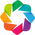

RECIPE: makeProcessedBias
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Up

Number of files: 250
Number of filtered files now: 55


RECIPE: makeProcessedBias
   PRIMITIVE: prepare
   ------------------
      PRIMITIVE: validateData
      -----------------------
      .
      PRIMITIVE: standardizeStructure
      -------------------------------
      .
      PRIMITIVE: standardizeHeaders
      -----------------------------
         PRIMITIVE: standardizeObservatoryHeaders
         ----------------------------------------
         Updating keywords that are common to all Gemini data
         .
         PRIMITIVE: standardizeInstrumentHeaders
         ---------------------------------------
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Updating keywords that are specific to GMOS
         Up

In [17]:
## GOA associates a bunch of bias frames (going 6 months back or something) more than necessary, which at times impact the quality of reduced science data product
## Let's down-filter the number of bias files


for K in np.unique(DF_object['object'].values):
    temp = DF_object[DF_object['object'].values==K]
    print (f"Unique observation dates for OBJECT {K}: {np.unique(temp['date'].values)}") # Note that "Twilight" is not interesting for us


## we will "group" by group_id first. This grouping to an extent will have taken care of the bias frames grouping required to reduce the actual science targets
for K, V in DF_bias.groupby('group_id'):
    print ("Number of files:", len(V))
    ## Let's narrow it down by filtering on dates (something closer to the science target observation dates)
    mask = ((V['date'] > datetime.date(2015, 4, 17)) & (V['date'] < datetime.date(2015, 4, 30))) | ((V['date'] > datetime.date(2015, 6, 15)) & (V['date'] < datetime.date(2015, 6, 18)))
    print ("Number of filtered files now:", np.sum(mask))
    dragons_reduce(list(V['file'].values[mask]), config_file=dragons_rc)

In [18]:
# Let's see how many files are now registered in the calibration database
for F in caldb.list_files():
    print (F)

FileData(name='N20150418S0453_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2015A-Q-86-5/reduction/calibrations/processed_bias')
FileData(name='N20150418S0503_bias.fits', path='/Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2015A-Q-86-5/reduction/calibrations/processed_bias')


In [ ]:
# Now, let's reduce the Twilight -- these are special type of flats. For this obs_ID, observers only gathered twilight flats and no regular flats

twilight = DF_object[DF_object['object'].values=='Twilight']

for K, V in twilight.groupby('group_id'):
    # ad = astrodata.open(V['file'].values[0])
    print (K, len(V), "\n")        
    dragons_reduce(list(V['file'].values), config_file=dragons_rc)

#### When one is reducing many exposures, for example, the case above with 276 files, then memory might be limited, so the intermediates files are qritten to disk. To get around this, user can increase the memory for the relevant primitive -- for the GMOS imaging routine, it's stackFrames (see below)

In [ ]:
## Now let's reduce one of the remaining two science targets


target1 = DF_object[DF_object['object'].values=='J1655+2533']

for K, V in target1.groupby('group_id'):
    print (K, len(V), "\n")        
    # when dealing with image reduction, sometines users will need to increase the memory used for reduction to facilitate stacking 100's of frames. 
    # This can be controlled with a user supplied parameter as shown below (very easily done on the GOATS frontend with the editable recipe)
    dragons_reduce(list(V['file'].values), uparams=[('stackFrames:memory', None)], config_file=dragons_rc)

Filename: /Users/monika.soraisam/Desktop/tomdev/real_goats/goats_data/ZTF18abtvjfy/GEM/GN-2015A-Q-86-5/reduction/N20150417S0223_image.fits
Tags: GEMINI GMOS IMAGE NORTH OVERSCAN_SUBTRACTED OVERSCAN_TRIMMED PREPARED
    PROCESSED PROCESSED_SCIENCE SIDEREAL

Pixels Extensions
Index  Content                  Type              Dimensions     Format
[ 0]   science                  NDAstroData       (1152, 1555)   float32
          .variance             ADVarianceUncerta (1152, 1555)   float32
          .mask                 ndarray           (1152, 1555)   uint16

Other Extensions
               Type        Dimensions
.HISTORY       Table       (18, 4)
.PROVENANCE    Table       (278, 4)


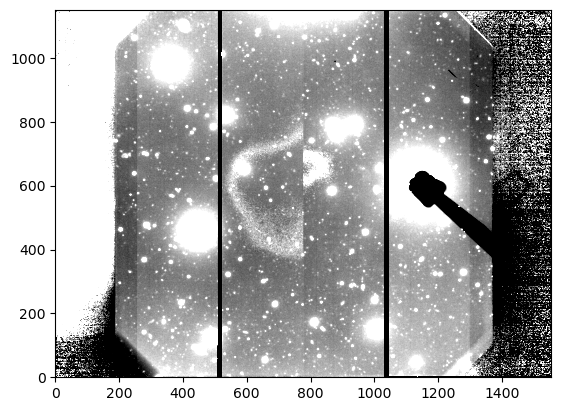

In [28]:
# Let's plot the reduced image

plt.close('all')
fig, ax = plt.subplots()
reduction_path = Path(f"{data_path}/{obsid}/reduction")
ad = astrodata.open(f'{reduction_path}/N20150417S0223_image.fits')
ad.info()
ax.imshow(ad[0].data, origin="lower", cmap='grey', vmin=np.percentile(ad[0].data, 10), vmax=np.percentile(ad[0].data, 80))
plt.show()